# Checking the use of wcs and sip

## Preparation
At first, we prepare the data with referring the generate_case7.py.

### Loading modules

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from argparse import ArgumentParser as ap
from astropy.table import QTable
from astropy.coordinates import SkyCoord, Longitude, Latitude, Angle
import numpy as np
import pandas as pd
import astropy.units as u
import warpfield as w

### Preparing functions

In [2]:
seed = 42
np.random.seed(seed)


def sip_distortion_generator(sip_x, sip_y):
  ''' Generate a distortion function compatible with the SIP notation.
  - c[m,n] = sip_x[m,n]
  - d[m,n] = sip_y[m,n]
  Values for (m,n) = (0,0), (1,0), (0,1) are ignored.
  '''
  def apply_sip(x,y,param,norm=1e6):
    d = np.zeros_like(x)
    narr = np.arange(param.size)
    for m,n in np.ndindex(param.shape):
      if n==0 and m==0: continue
      if n==1 and m==0: continue
      if n==0 and m==1: continue
      d += param[m,n]*(x/norm)**m*(y/norm)**n*(norm**(m+n))
    return d

  def distortion(position):
    position = np.array(position)
    x,y = position[0].copy(), position[1].copy()
    position[0] += apply_sip(x,y,sip_x)
    position[1] += apply_sip(x,y,sip_y)
    return position

  return distortion

### Loading the source data

In [3]:
from astropy.io import ascii as asc

table = asc.read('case7_source_list.txt')
sources = SkyCoord(table['ra'], table['dec'], frame='icrs')

### Preparing SIP coefficients (AP/BP matrices as c/d)
The values below is written in case7_challenge_00.txt.

In [4]:
c = np.zeros(shape=(3, 3))
d = np.zeros(shape=(3, 3))

c[0,2]=-2.34153374723336e-09
c[1,1]=1.5792128155073916e-08
c[1,2]=7.674347291529089e-15
c[2,0]=-4.694743859349522e-09
c[2,1]=5.4256004358596465e-15
c[2,2]=-4.6341769281246224e-21
d[0,2]=-1.913280244657798e-08
d[1,1]=-5.622875292409728e-09
d[1,2]=-1.0128311203344238e-14
d[2,0]=3.1424733259527392e-09
d[2,1]=-9.08024075521211e-15
d[2,2]=-1.4123037013352912e-20


### Observing the sources
The pointing parameters are the same as the 0-th field written in case7_challenge_00_pointing.txt.

In [5]:
lon = Longitude(265.62153148319356*u.deg)
lat = Latitude(-28.851511272277236*u.deg)
pa = Angle(301.8490035010801*u.deg)

center = SkyCoord(lon, lat, frame='icrs')

distortion = sip_distortion_generator(c, d)
jasmine = w.Telescope(center, pa)
jasmine.set_distortion(distortion)

position = jasmine.observe(sources)[0]

### Checking the distribution

Text(0, 0.5, 'y (um)')

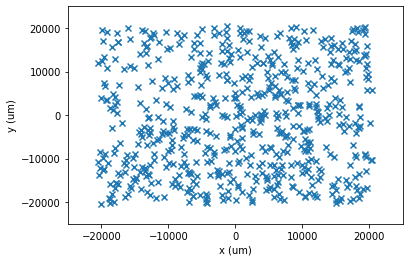

In [6]:
import matplotlib.pylab as plt

plt.scatter(position['x'], position['y'], marker='x')
plt.xlim([-25000, 25000])
plt.ylim([-25000, 25000])
plt.xlabel('x (um)')
plt.ylabel('y (um)')

Text(0, 0.5, 'dec (deg)')

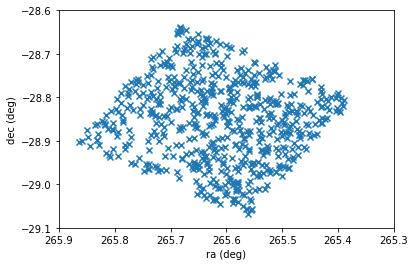

In [7]:
plt.scatter(position['ra'], position['dec'], marker='x')
plt.xlim([265.9, 265.3])
plt.ylim([-29.1, -28.6])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

The position angle was set to about 300 deg., but apparently the position angle seems to be about 60 deg, if it is defined as the angle between the Y axis and N axis measured in anti-clockwise direction.

## WCS analysis
At first, we define a wcs-generator function.

In [8]:
from astropy.wcs import WCS
from astropy.wcs import Sip

def wcs_generator(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa_ptg*u.deg), np.sin(pa_ptg*u.deg)],
              [-np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

### Calculating the plate scale

In [9]:
f=jasmine.optics.focal_length*u.m
scale=(1.*u.um/f*180./np.pi).si.value*u.deg/u.um

### Constructing wcs1 (No distortion)

In [10]:
wcs1 = wcs_generator(lon.value, lat.value, pa.value, scale.value) # scale in deg/um.

### Converting x/y to radec (without considering distortion)

In [11]:
xy0 = np.concatenate(([position['x']], [position['y']])).T
radec = wcs1.all_pix2world(xy0, 0)

### Comparing x/y

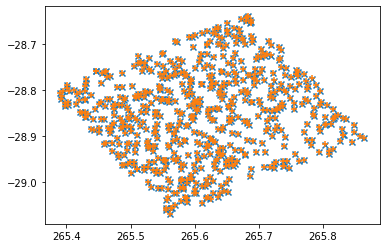

In [12]:
plt.scatter(radec[:,0], radec[:,1], marker='x', label='converted without dist.')
plt.scatter(position['ra'], position['dec'], marker='+', label='true')

The xy values obtained with all_pix2world (but no distortion) is compared with that calculated by Ohsawa-san's tool (with distortion).
We cannot see significant difference in this plot.

### Histogram of the differences in ra/dec

(array([  6.,  10.,  13.,  18.,  26.,  39.,  49.,  61., 120., 286.]),
 array([-7.56511314e-05, -6.80860786e-05, -6.05210257e-05, -5.29559729e-05,
        -4.53909201e-05, -3.78258673e-05, -3.02608145e-05, -2.26957617e-05,
        -1.51307089e-05, -7.56565606e-06, -6.03247230e-10]),
 <BarContainer object of 10 artists>)

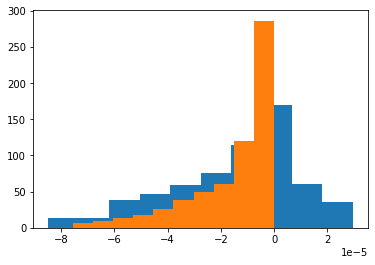

In [13]:
dra  = radec[:,0] - position['ra']
plt.hist(dra)
ddec = radec[:,1] - position['dec']
plt.hist(ddec)

The difference is of ~10^-5. If the distortion parameters are set to zero, the difference reduces to ~10^-14.

### wcs2 (AP/BP matrices are set)

In [14]:
wcs2 = wcs_generator(lon.value, lat.value, pa.value, scale.value, ap=c, bp=d) # scale in deg/um.

### Calculating radec with all_pix2world -> radec2

In [17]:
radec2 = wcs2.all_pix2world(xy0, 0)

### Comparison between original ra/dec and calculated ra/dec

(array([  6.,  10.,  13.,  18.,  26.,  39.,  49.,  61., 120., 286.]),
 array([-7.56511314e-05, -6.80860786e-05, -6.05210257e-05, -5.29559729e-05,
        -4.53909201e-05, -3.78258673e-05, -3.02608145e-05, -2.26957617e-05,
        -1.51307089e-05, -7.56565606e-06, -6.03247230e-10]),
 <BarContainer object of 10 artists>)

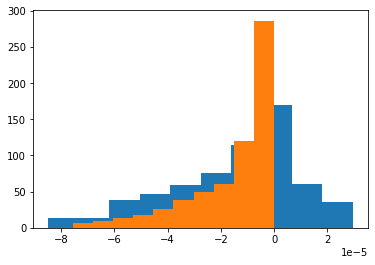

In [16]:
dra  = radec2[:,0] - position['ra']
plt.hist(dra)
ddec = radec2[:,1] - position['dec']
plt.hist(ddec)

This plot looks very similar to the previous plot. Therefore, we can see that the AP/BP matrices are not used in the all_pix2world calculation. It seems to be natural because the matrices define the way to convert sky coordinates to pixel coordinates (inversion process of all_pix2world).

### Converting ra/dec to x/y

At first, we define radec0 array which contains ra/dec values from the source file.

In [18]:
radec0 = np.concatenate(([position['ra']], [position['dec']])).T

### Using wcs1 (no distortion) -> xy1

(array([ 51., 161.,  86.,  68.,  76.,  55.,  54.,  32.,  27.,  18.]),
 array([-1.42727681, -0.38933056,  0.64861569,  1.68656194,  2.7245082 ,
         3.76245445,  4.8004007 ,  5.83834695,  6.8762932 ,  7.91423945,
         8.9521857 ]),
 <BarContainer object of 10 artists>)

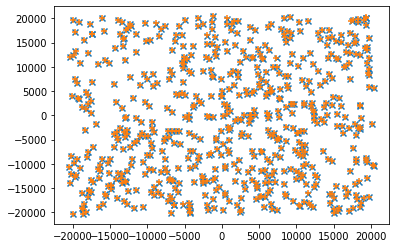

In [21]:
xy1 = wcs1.all_world2pix(radec0, 0)
plt.scatter(xy0[:, 0], xy0[:, 1], marker='x')
plt.scatter(xy1[:, 0], xy1[:, 1], marker='+')

We cannot see significant difference.

### Histogram of difference between true xy (xy0) and calculated xy (xy1)

(array([ 51., 161.,  86.,  68.,  76.,  55.,  54.,  32.,  27.,  18.]),
 array([-1.42727681, -0.38933056,  0.64861569,  1.68656194,  2.7245082 ,
         3.76245445,  4.8004007 ,  5.83834695,  6.8762932 ,  7.91423945,
         8.9521857 ]),
 <BarContainer object of 10 artists>)

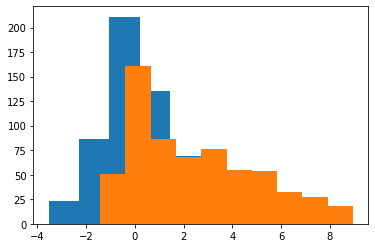

In [29]:
dx=xy1[:,0] - xy0[:,0]
plt.hist(dx)
dy=xy1[:,1] - xy0[:,1]
plt.hist(dy)

### Using wcs2 (with AP/BP matrices) -> xy2

In [30]:
xy2 = wcs2.all_world2pix(radec0, 0)

### Histogram of difference between true xy (xy0) and calculated xy (xy2)

(array([ 51., 161.,  86.,  68.,  76.,  55.,  54.,  32.,  27.,  18.]),
 array([-1.42727681, -0.38933056,  0.64861569,  1.68656194,  2.7245082 ,
         3.76245445,  4.8004007 ,  5.83834695,  6.8762932 ,  7.91423945,
         8.9521857 ]),
 <BarContainer object of 10 artists>)

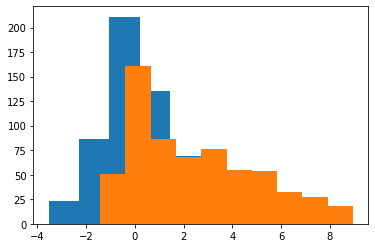

In [31]:
dx = xy2[:,0] - xy0[:,0]
plt.hist(dx)
dy = xy2[:,1] - xy0[:,1]
plt.hist(dy)

This plot looks very similar to the previous plot obtainted with wcs1. It seems that the AP/BP matrices are not used in all_world2pix function.

### Another method for converting radec to xy with using AP/BP matrices -> xy3

In [32]:
xy3 = wcs2.sip_foc2pix(wcs2.wcs_world2pix(radec0, 0)-wcs2.wcs.crpix, 0)

### Histogram of the difference between xy0 and xy3

(array([  5.,   5.,  17.,  28., 161., 351.,  29.,  21.,   3.,   8.]),
 array([-0.15454939, -0.12420644, -0.09386349, -0.06352054, -0.03317759,
        -0.00283464,  0.02750831,  0.05785126,  0.08819421,  0.11853716,
         0.1488801 ]),
 <BarContainer object of 10 artists>)

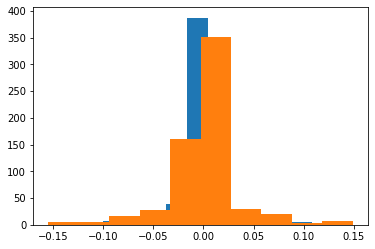

In [33]:
dx = xy3[:,0] - xy0[:,0]
plt.hist(dx)
dy = xy3[:,1] - xy0[:,1]
plt.hist(dy)

THe difference is very small. This method seems to successfully convert radec to xy with using AP/BP matrices.

If we want to use AP/BP matrices for converting radec to xy pixel coordinates, we have to use the last method. The all_world2pix method can treat only A/B matrices (not AP/BP matrices). Some discussion is available on the site below.

https://github.com/astropy/astropy/issues/3675